# Traffic Sign Recognition with Tensorflow

In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# Allow image embeding in notebook
%matplotlib inline

C:\Users\Chris.Cui\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Parse and Load the Training Data

The **Training** directory contains sub-directories with sequental numerical names from 00000 to 00061. The name of the directory represents the labels from 0 to 61, and the images in each directory represent the traffic signs that belong to that label. The images are saved in the not-so-common .ppm format, but luckily, this format is supported in the skimage library.

In [2]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [3]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

In [4]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

## Explore the Dataset

How many images and labels do we have?

In [5]:
# Load training and testing datasets.
ROOT_PATH = "./"
train_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Training")
test_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Testing")

images, labels = load_data(train_data_dir)

Display the first image of each label.

Unique Labels: 62
Total Images: 4575


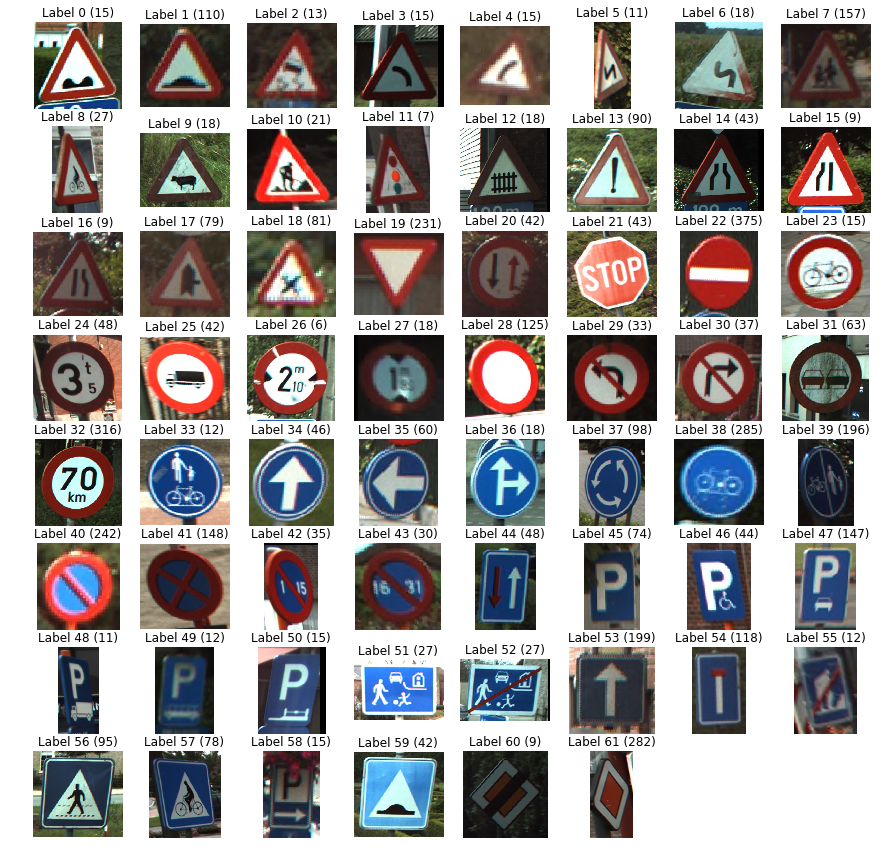

In [6]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))
display_images_and_labels(images, labels)

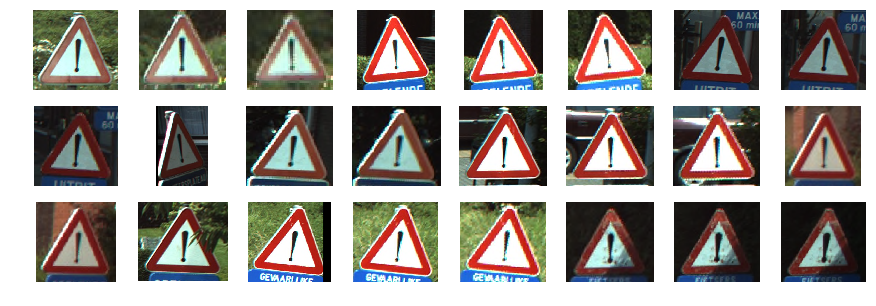

In [7]:
#Display the warning signs
display_label_images(images, 13)

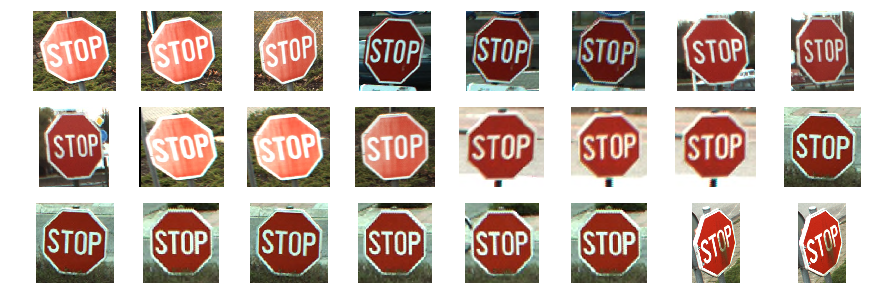

In [8]:
# Display stop signs 
display_label_images(images, 21)

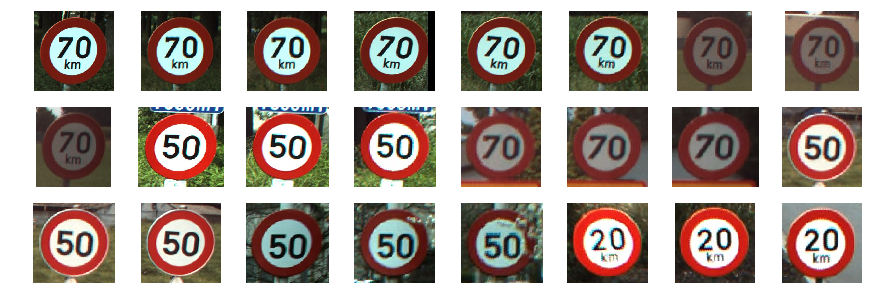

In [9]:
#Display the speed limit signs
display_label_images(images, 32)

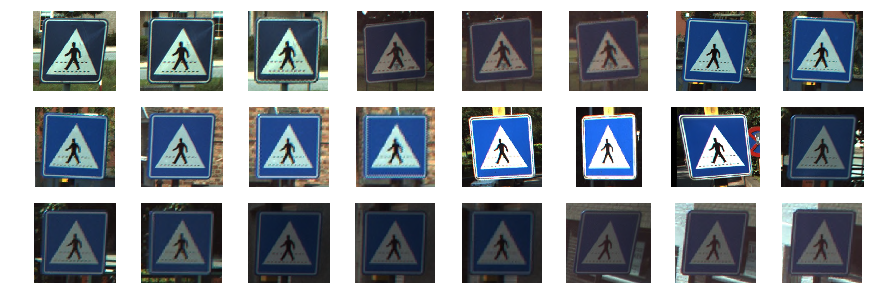

In [10]:
#Display the pedestrians signs
display_label_images(images, 56)

In [11]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (141, 142, 3), min: 0, max: 255
shape: (120, 123, 3), min: 0, max: 255
shape: (105, 107, 3), min: 0, max: 255
shape: (94, 105, 3), min: 7, max: 255
shape: (128, 139, 3), min: 0, max: 255


The sizes seem to hover around 128x128. If we resize them to, say, 32x32, we'll have reduced the data and the model size by a factor of 16. And 32x32 is probably still big enough to recognize the signs, so let's go with that. 

I'm also in the habit of frequently printing the min() and max() values. It's a simple way to verify the range of your data and catch bugs early.

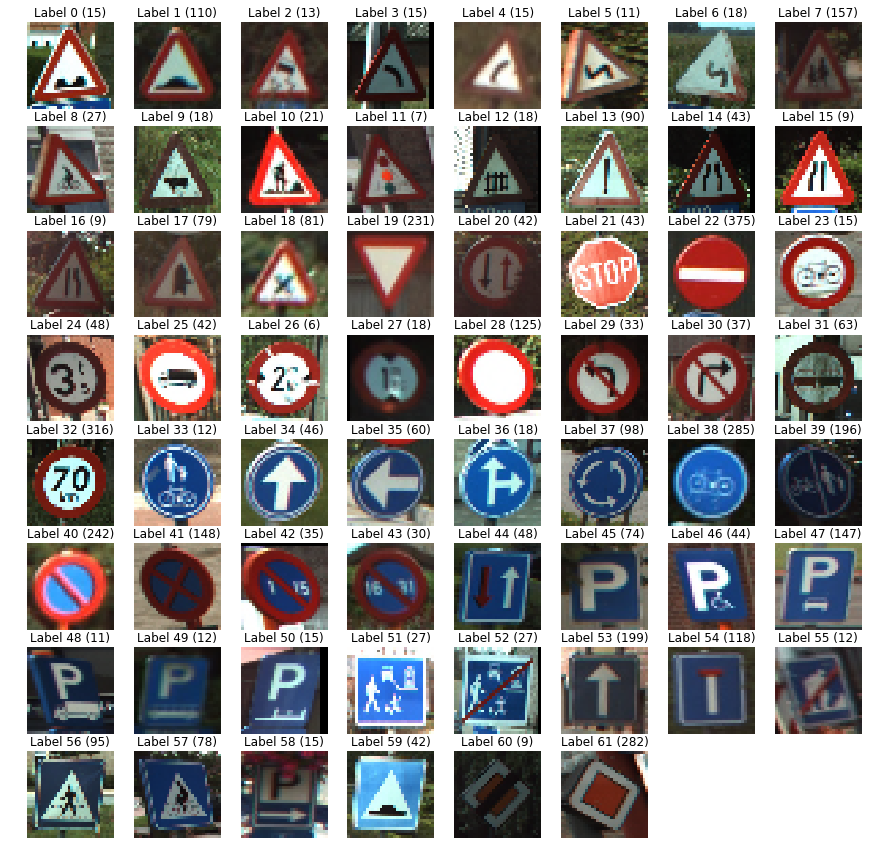

In [12]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]

display_images_and_labels(images32, labels)

The 32x32 images are not as sharp but still recognizable. Note that the display above shows the images larger than their real size because the matplotlib library tries to fit them to the grid size. Let's print the sizes of a few images to verify that we got it right.

In [13]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.007391237745097998, max: 1.0
shape: (32, 32, 3), min: 0.003576899509805663, max: 1.0
shape: (32, 32, 3), min: 0.0015567555147030507, max: 1.0
shape: (32, 32, 3), min: 0.05677466299019637, max: 0.9692670036764703
shape: (32, 32, 3), min: 0.026654411764708015, max: 0.98952205882353


The sizes are correct. But check the min and max values! They now range from 0 to 1.0, which is different from the 0-255 range we saw above. The resizing function did that transformation for us. Normalizing values to the range 0.0-1.0 is very common so we'll keep it. But remember to multiply by 255 if you later want to convert the images back to the normal 0-255 range.

# Minimum Viable Model

In [14]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)


labels:  (4575,) 
images:  (4575, 32, 32, 3)


In [15]:
# change the data format
labels_c = tf.keras.utils.to_categorical(labels_a, num_classes=62)
print("labels: ", labels_c.shape, "\nimages: ", images_a.shape)


labels:  (4575, 62) 
images:  (4575, 32, 32, 3)


## Using the Model

The session object contains the values of all the variables in our model (i.e. the weights). 

In [16]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]
 
sample_images = np.array(sample_images)    
sample_labels = np.array(sample_labels)
print(sample_images.shape)    
print(sample_labels)       


(10, 32, 32, 3)
[53 38 24 22 19 41 42 32 21 61]


In [17]:
model = tf.keras.models.load_model('my_model.h5')
model.summary()

predicted = model.predict(sample_images, batch_size=32)
# print(predicted)
predicted =np.argmax(predicted, axis=1)
print('Model Output:', predicted)
print('Sample labels:',sample_labels)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
__________

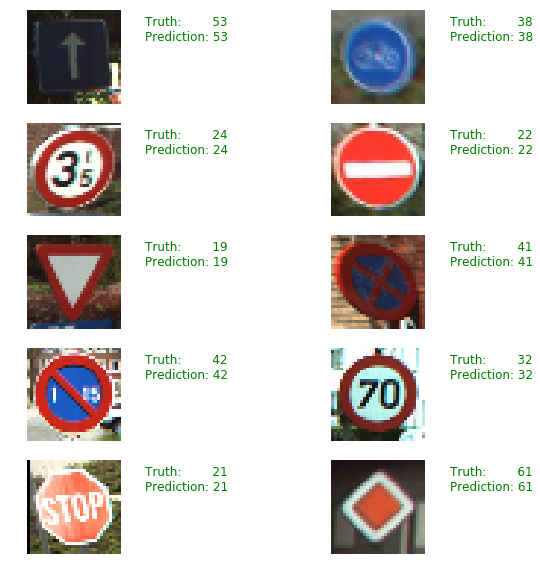

In [18]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])


## Evaluation

It's fun to visualize the results, but we need a more precise way to measure the accuracy of our model. Also, it's important to test it on images that it hasn't seen. And that's where the validation data set comes into play.

In [19]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

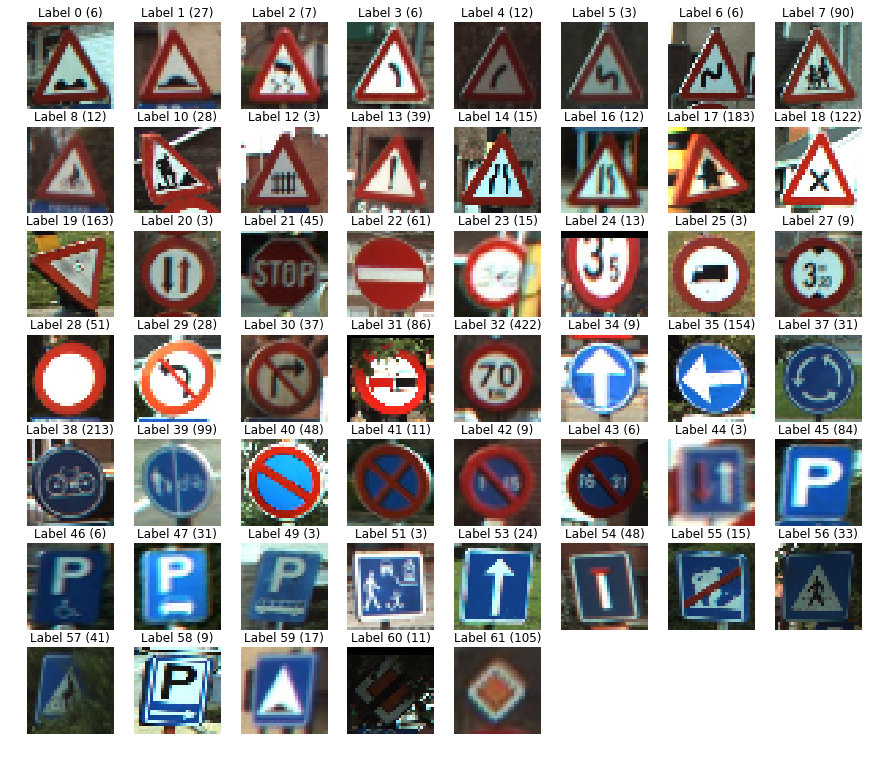

In [20]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [21]:
test_samples = np.array(test_images32)

# Run predictions against the full test set.
predicted = model.predict(test_samples, batch_size=32)
# print(predicted)
predicted =np.argmax(predicted, axis=1)

# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.977


In [22]:
# save the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
__________

In [23]:
labels_c = tf.keras.utils.to_categorical(np.array(test_labels, dtype = np.int), num_classes=62)

loss = model.evaluate(test_samples, labels_c)

print("Restored model, loss: {:5.2f}%".format(loss))

#print("Restored model, accuracy: {:5.2f}%".format(100*acc))

2520/2520 [==============================] - 2s 906us/step
Restored model, loss:  0.14%


In [24]:
print(test_samples.shape)

print(labels_c.shape)

(2520, 32, 32, 3)
(2520, 62)


# End
